https://sklearn-genetic-opt.readthedocs.io/en/stable/tutorials/basic_usage.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn_genetic import GAFeatureSelectionCV
from sklearn_genetic.plots import plot_fitness_evolution
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('..\Data_preprocessing\SHP2_train_descriptors_2741.csv')
data

,SMILES,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,IC50(microM)
0,Cc1nc(cc(=O)n1-c1cccc(Cl)c1Cl)N1CCC2(Cc3ccccc3...,12.992564,-0.169513,12.992564,0.068072,0.609173,455.389,431.197,454.132717,160,...,0,0,0,0,0,0,0,0,0,0.0008
1,N[C@@H]1CCCC11CCN(CC1)c1cnc(Sc2cccc(NC(=O)c3c(...,13.061568,-0.781987,13.061568,0.246174,0.340043,597.145,563.881,596.208486,216,...,0,0,0,0,0,0,0,0,0,0.001
2,N[C@@H]1c2ccccc2CC11CCN(CC1)c1nc(N)c(C2=C(Cl)C...,12.340744,-0.676170,12.340744,0.017202,0.606557,485.419,459.211,484.154515,172,...,0,0,0,0,0,0,0,0,0,0.001
3,N[C@@H]1C[C@H](O)CC11CCN(CC1)c1ncc(Sc2cccc(Cl)...,10.063495,-0.264210,10.063495,0.058620,0.603375,464.422,441.238,463.100037,158,...,0,0,0,0,0,0,0,0,0,0.0012
4,C[C@@H]1OCC2(CCN(CC2)c2ncc(Sc3cccc(Cl)c3Cl)c3n...,6.464779,0.086398,6.464779,0.086398,0.614971,464.422,441.238,463.100037,158,...,0,0,0,0,0,0,0,0,0,0.0015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2736,CC(C)(C)c1ccc(Oc2ccc(NC(=O)C3=CO[C@@H](O[C@@H]...,13.333207,-1.619179,13.333207,0.045316,0.248676,597.661,558.349,597.257396,232,...,0,0,0,0,0,0,0,0,0,100.0
2737,O=C(O)C1=CO[C@@H](O[C@@H]2O[C@H](COCc3ccccc3)[...,12.516733,-1.051943,12.516733,0.156681,0.076526,824.967,772.551,824.356048,316,...,0,0,0,0,0,0,0,0,0,3.32
2738,CCOS(=O)(=O)/C=C/c1ccc(OCC2=CC[C@@H]3C(C(=O)Nc...,13.462705,-3.710843,13.462705,0.073907,0.112068,679.791,642.495,679.223988,252,...,0,0,0,0,0,0,0,0,0,1.24
2739,CCOS(=O)(=O)/C=C/c1ccc(OCC2=CC[C@@H]3C(C(=O)Nc...,13.659530,-3.730454,13.659530,0.066112,0.099496,793.132,757.852,791.095528,264,...,0,0,0,0,0,0,0,0,0,3.97


In [3]:
def activity(s):
    if s[0] == '<':
        if float(s[1:]) <= 1:
            return 1
        else:
            return np.nan
    elif s[0] == '>':
        if float(s[1:]) >= 1:
            return 0
        else:
            return np.nan
    else:
        if float(s) > 1:
            return 0
        else:
            return 1

In [4]:
data['TARGET'] = data['IC50(microM)'].apply(activity)
data

,SMILES,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,IC50(microM),TARGET
0,Cc1nc(cc(=O)n1-c1cccc(Cl)c1Cl)N1CCC2(Cc3ccccc3...,12.992564,-0.169513,12.992564,0.068072,0.609173,455.389,431.197,454.132717,160,...,0,0,0,0,0,0,0,0,0.0008,1.0
1,N[C@@H]1CCCC11CCN(CC1)c1cnc(Sc2cccc(NC(=O)c3c(...,13.061568,-0.781987,13.061568,0.246174,0.340043,597.145,563.881,596.208486,216,...,0,0,0,0,0,0,0,0,0.001,1.0
2,N[C@@H]1c2ccccc2CC11CCN(CC1)c1nc(N)c(C2=C(Cl)C...,12.340744,-0.676170,12.340744,0.017202,0.606557,485.419,459.211,484.154515,172,...,0,0,0,0,0,0,0,0,0.001,1.0
3,N[C@@H]1C[C@H](O)CC11CCN(CC1)c1ncc(Sc2cccc(Cl)...,10.063495,-0.264210,10.063495,0.058620,0.603375,464.422,441.238,463.100037,158,...,0,0,0,0,0,0,0,0,0.0012,1.0
4,C[C@@H]1OCC2(CCN(CC2)c2ncc(Sc3cccc(Cl)c3Cl)c3n...,6.464779,0.086398,6.464779,0.086398,0.614971,464.422,441.238,463.100037,158,...,0,0,0,0,0,0,0,0,0.0015,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2736,CC(C)(C)c1ccc(Oc2ccc(NC(=O)C3=CO[C@@H](O[C@@H]...,13.333207,-1.619179,13.333207,0.045316,0.248676,597.661,558.349,597.257396,232,...,0,0,0,0,0,0,0,0,100.0,0.0
2737,O=C(O)C1=CO[C@@H](O[C@@H]2O[C@H](COCc3ccccc3)[...,12.516733,-1.051943,12.516733,0.156681,0.076526,824.967,772.551,824.356048,316,...,0,0,0,0,0,0,0,0,3.32,0.0
2738,CCOS(=O)(=O)/C=C/c1ccc(OCC2=CC[C@@H]3C(C(=O)Nc...,13.462705,-3.710843,13.462705,0.073907,0.112068,679.791,642.495,679.223988,252,...,0,0,0,0,0,0,0,0,1.24,0.0
2739,CCOS(=O)(=O)/C=C/c1ccc(OCC2=CC[C@@H]3C(C(=O)Nc...,13.659530,-3.730454,13.659530,0.066112,0.099496,793.132,757.852,791.095528,264,...,0,0,0,0,0,0,0,0,3.97,0.0


In [5]:
data = data.dropna()

In [6]:
data.shape

(2739, 211)

In [7]:
X = data.iloc[:,1:-2]
y = data.iloc[:,-1]

In [8]:
X.shape

(2739, 208)

In [9]:
y.shape

(2739,)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 50 Generations

In [11]:
clf = RandomForestClassifier()

evolved_estimator = GAFeatureSelectionCV(
    estimator=clf,
    cv=5,
    scoring="accuracy",
    population_size=100,
    generations=50,
    n_jobs=3,
    verbose=True,
    keep_top_k=2,
    crossover_probability=0.5,
    mutation_probability=0.04,
    max_features=20, 
    tournament_size=3,
    elitism=True,
)

In [ ]:
evolved_estimator.fit(X, y)
features = evolved_estimator.best_features_

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	100   	0.907678	0.0253528  	0.935746   	0.763043   
1  	99    	0.923251	0.00638194 	0.935746   	0.898516   
2  	115   	0.928146	0.00387429 	0.935746   	0.914947   
3  	114   	0.931328	0.00352384 	0.936112   	0.923338   
4  	108   	0.93332 	0.00254146 	0.937207   	0.92772    
5  	105   	0.934612	0.00181597 	0.937207   	0.929182   
6  	106   	0.935393	0.00101587 	0.937207   	0.930637   
7  	100   	0.935845	0.000642363	0.937207   	0.932827   
8  	116   	0.935886	0.000847787	0.937207   	0.931732   
9  	93    	0.935959	0.000892786	0.937207   	0.932827   
10 	115   	0.936101	0.00101203 	0.937207   	0.931368   
11 	96    	0.936576	0.000844776	0.937207   	0.930272   
12 	107   	0.936784	0.000864816	0.937207   	0.931367   
13 	113   	0.936835	0.00105522 	0.937207   	0.932462   
14 	101   	0.936944	0.000876091	0.937207   	0.932097   
15 	110   	0.937068	0.000652478	0.937207   	0.932827   
16 	112   	0.936886	0.00101181 	0.937207   	0.93

In [20]:
# Predict only with the subset of selected features
y_predict_ga = evolved_estimator.predict(X.iloc[:,features])
accuracy = accuracy_score(y, y_predict_ga)

E:\MY_FILES\Anaconda\envs\thesis\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [24]:
print(X.columns[evolved_estimator.best_features_])
print("accuracy score: ", "{:.2f}".format(accuracy))

Index(['HeavyAtomMolWt', 'MaxAbsPartialCharge', 'MinAbsPartialCharge',
       'BCUT2D_MRHI', 'BalabanJ', 'Chi3v', 'HallKierAlpha', 'Ipc', 'PEOE_VSA6',
       'PEOE_VSA9', 'SlogP_VSA6', 'SlogP_VSA8', 'MolLogP', 'fr_Ar_N',
       'fr_Nhpyrrole', 'fr_alkyl_halide', 'fr_furan', 'fr_nitroso',
       'fr_piperdine', 'fr_thiocyan'],
      dtype='object')
accuracy score:  0.99


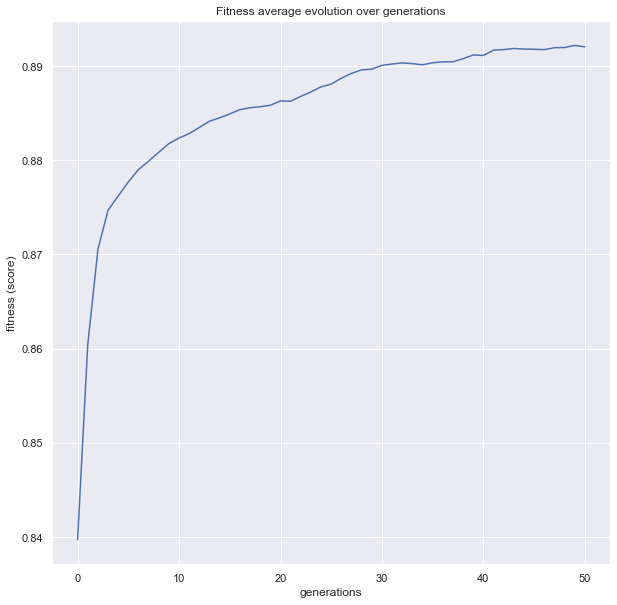

In [23]:
plot = plot_fitness_evolution(evolved_estimator, metric="fitness")
plt.show()